# ECS 171 Project: Detecting Cyber Intrusion on IoT Traffic Data


#### Completed by Matthew Armstrong, Karthik Palanisamy, Rahul Prabhu, Matthew Tom, and Kyle Tsuji
##### *Professor Solares, ECS 171: Machine Learning - UC Davis Summer 2023*

## Imports and Data Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get dataset from github archive
!wget https://github.com/matthewarmstr/ECS-171-Project/raw/main/IoT_Intrusion.zip
!unzip IoT_Intrusion.zip

--2023-09-02 04:42:41--  https://github.com/matthewarmstr/ECS-171-Project/raw/main/IoT_Intrusion.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthewarmstr/ECS-171-Project/main/IoT_Intrusion.zip [following]
--2023-09-02 04:42:41--  https://raw.githubusercontent.com/matthewarmstr/ECS-171-Project/main/IoT_Intrusion.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48101046 (46M) [application/zip]
Saving to: ‘IoT_Intrusion.zip’

IoT_Intrusion.zip   100%[===================>]  45.87M   162MB/s    in 0.3s    

2023-09-02 04:42:43 (162 MB/s) - ‘IoT_Intrusion.zip’ saved [48101046/48101046]

Ar

In [3]:
# load data file
intru_table = pd.read_csv("IoT_Intrusion.csv")
intru_labels_removed = intru_table.drop(columns=['label'])

## Data Preprocessing

In [4]:
# save attribute and label strings
attribute_names = intru_table.columns.drop('label')

intru_label_names = ['Backdoor_Malware', 'BenignTraffic', 'BrowserHijacking', 'CommandInjection', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ICMP_Flood', 'DDoS-ICMP_Fragmentation',
                     'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 'DDoS-SlowLoris', 'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DDoS-UDP_Fragmentation',
                     'DNS_Spoofing', 'DictionaryBruteForce', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'MITM-ArpSpoofing', 'Mirai-greeth_flood', 'Mirai-greip_flood',
                     'Mirai-udpplain', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PingSweep', 'Recon-PortScan', 'SqlInjection', 'Uploading_Attack', 'VulnerabilityScan', 'XSS']

In [5]:
# check if each attribute is normally distributed
for col_name in intru_labels_removed:
    print(col_name, shapiro(intru_labels_removed[col_name]), "\n\tmin:", np.min(intru_labels_removed[col_name]), "; max:", np.max(intru_labels_removed[col_name]))

flow_duration ShapiroResult(statistic=0.0039147138595581055, pvalue=0.0) 
	min: 0.0 ; max: 99435.76178
Header_Length ShapiroResult(statistic=0.1560286283493042, pvalue=0.0) 
	min: 0.0 ; max: 9815555.0
Protocol Type ShapiroResult(statistic=0.6346024870872498, pvalue=0.0) 
	min: 0.0 ; max: 47.0
Duration ShapiroResult(statistic=0.18483299016952515, pvalue=0.0) 
	min: 0.0 ; max: 255.0
Rate ShapiroResult(statistic=0.05927008390426636, pvalue=0.0) 
	min: 0.0 ; max: 7340032.0
Srate ShapiroResult(statistic=0.05927008390426636, pvalue=0.0) 
	min: 0.0 ; max: 7340032.0
Drate ShapiroResult(statistic=9.66191291809082e-05, pvalue=0.0) 
	min: 0.0 ; max: 0.848465429
fin_flag_number ShapiroResult(statistic=0.3147495985031128, pvalue=0.0) 
	min: 0 ; max: 1
syn_flag_number ShapiroResult(statistic=0.499664306640625, pvalue=0.0) 
	min: 0 ; max: 1
rst_flag_number ShapiroResult(statistic=0.32291436195373535, pvalue=0.0) 
	min: 0 ; max: 1
psh_flag_number ShapiroResult(statistic=0.3181704878807068, pvalue=0.0)

In [5]:
# complete one-hot encoding on intrusion labels
ohe = OneHotEncoder()
ohe_intru_labels = pd.DataFrame(ohe.fit_transform(intru_table['label'].values.reshape(-1,1)).toarray(), columns=intru_label_names)

# attributes are NOT normally distributed - normalize traffic attribute data
scaler = MinMaxScaler()
norm_intru_labels_removed = pd.DataFrame(scaler.fit_transform(intru_labels_removed), columns=attribute_names)

# create table with normalized data and string labels (commented for now - alters above variable)
# norm_intru_with_classes = norm_intru_labels_removed
# norm_intru_with_classes['label'] = intru_table['label']

In [6]:
# we decided to remove the following attributes since they provide no meaningful contributions to the model
exclude = ['SMTP', 'Telnet', 'IRC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'Covariance', 'Variance']

relevant = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
         'syn_count', 'fin_count', 'urg_count', 'rst_count', 'IPv', 'LLC', 'DNS', 'SSH', 'TCP', 'UDP',
         'DHCP', 'ARP', 'ICMP', 'IAT', 'Number', 'Mangitue', 'Radius', 'Weight']

In [7]:
# remove unwanted data attribute columns
attribute_data = norm_intru_labels_removed.drop(columns=exclude)

# split data for all model runs
X_train, X_test, y_train, y_test = train_test_split(attribute_data, ohe_intru_labels, train_size=0.9, random_state=5)

## Data Visualization

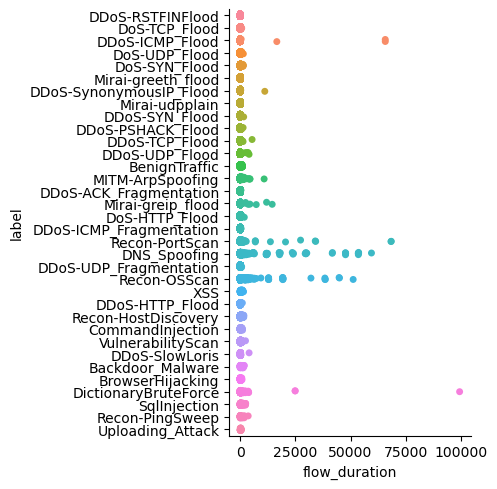

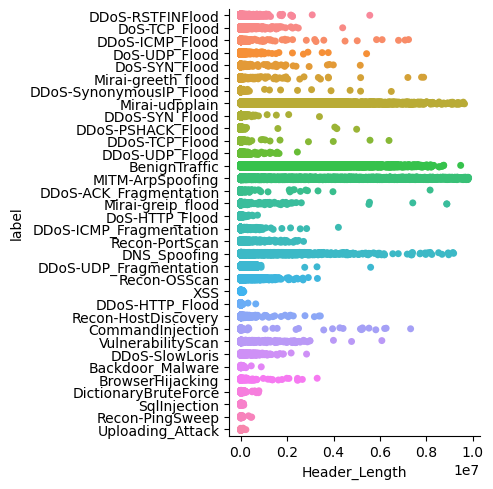

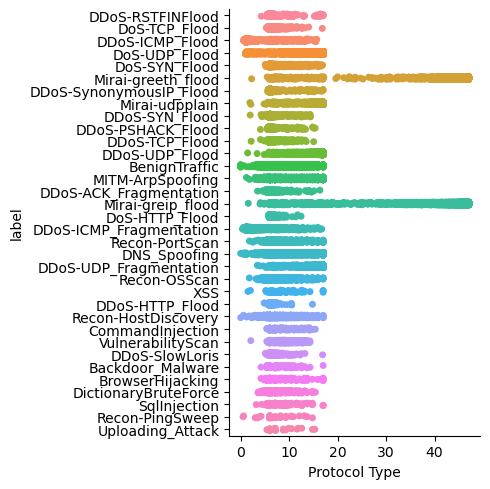

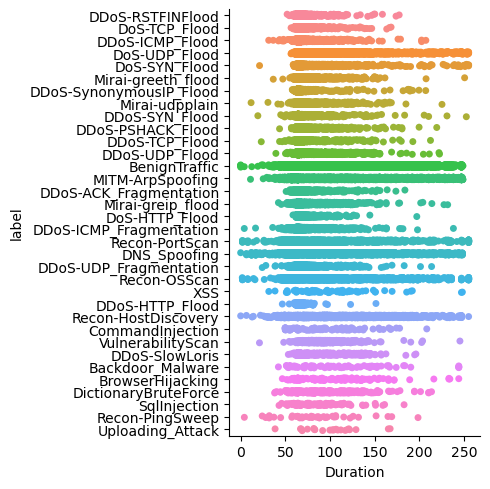

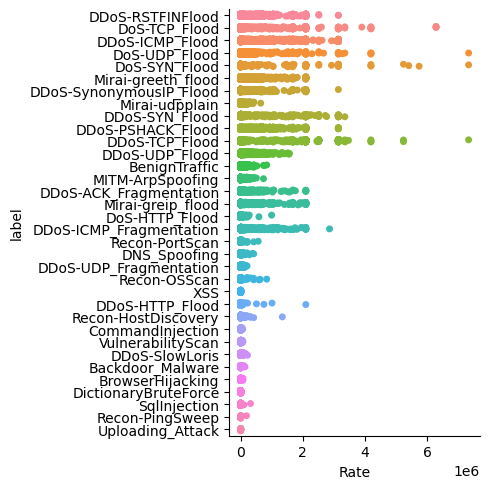

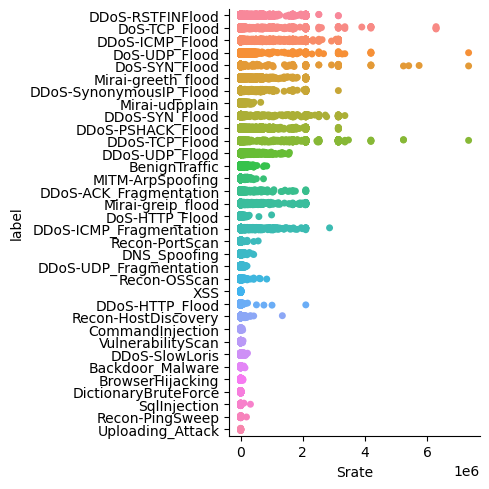

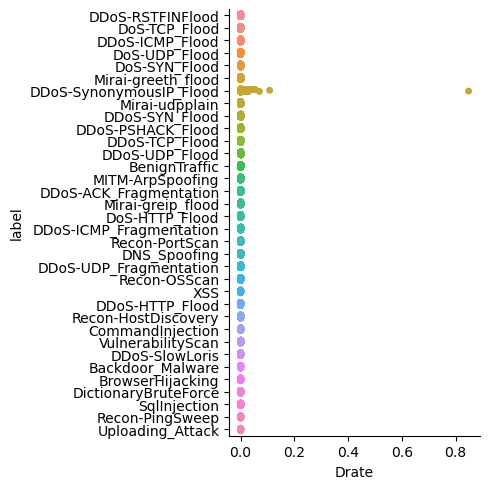

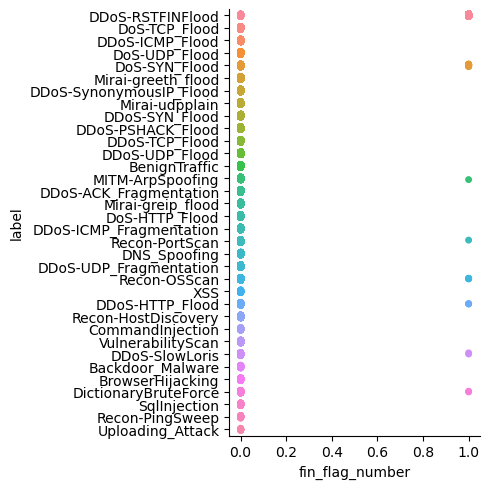

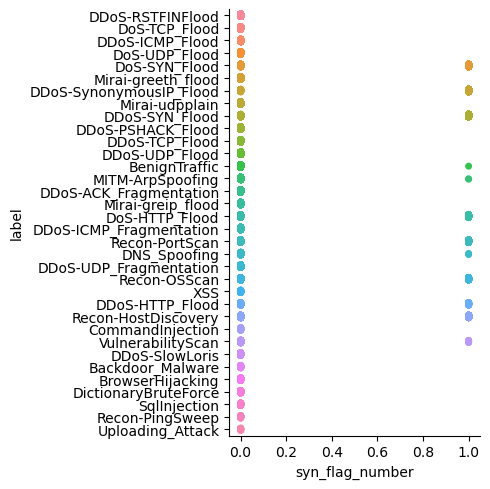

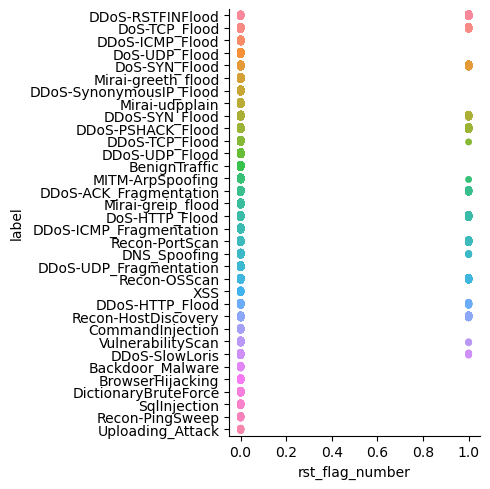

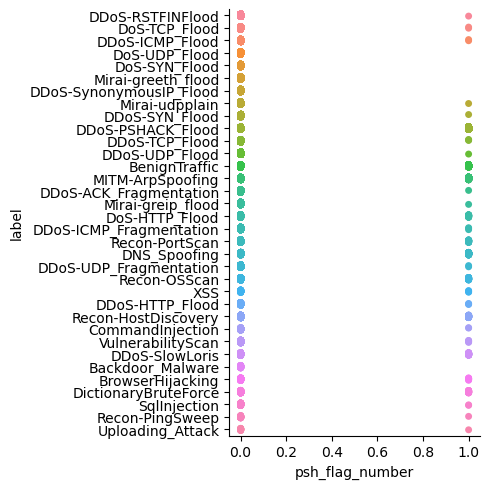

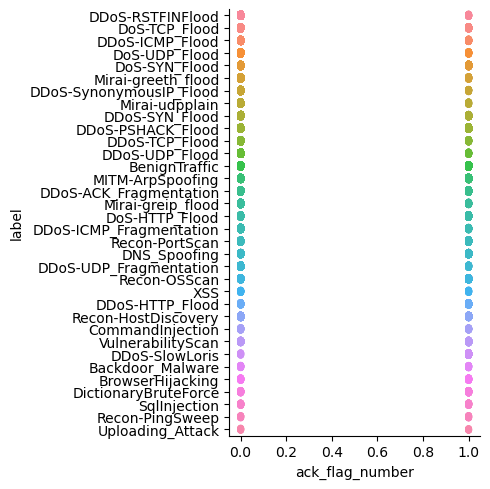

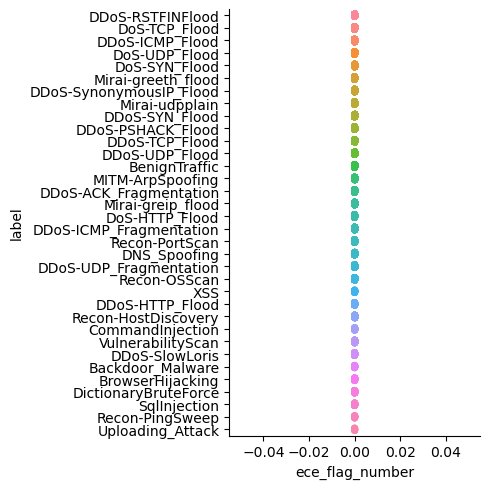

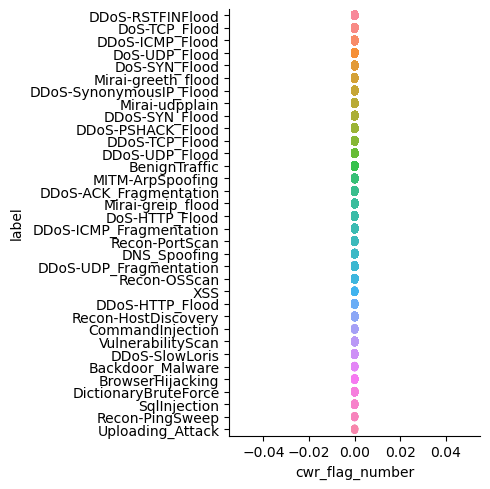

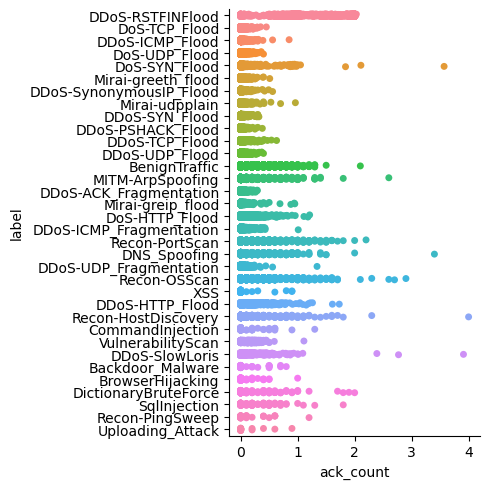

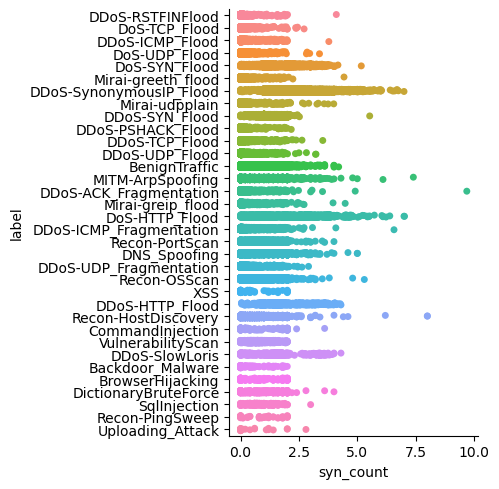

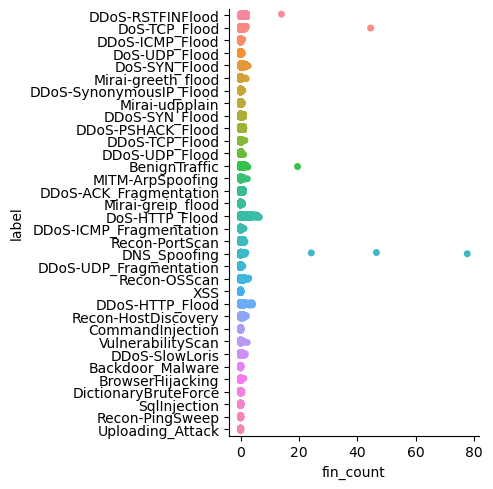

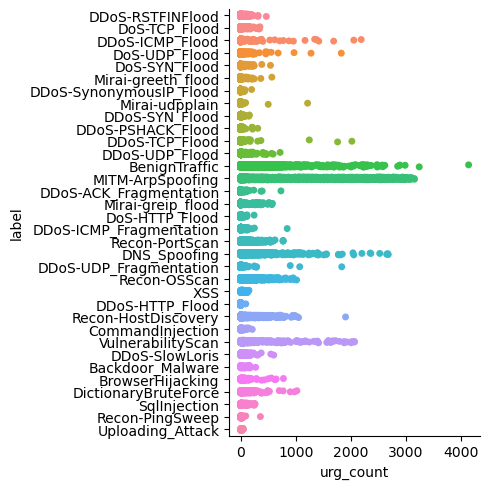

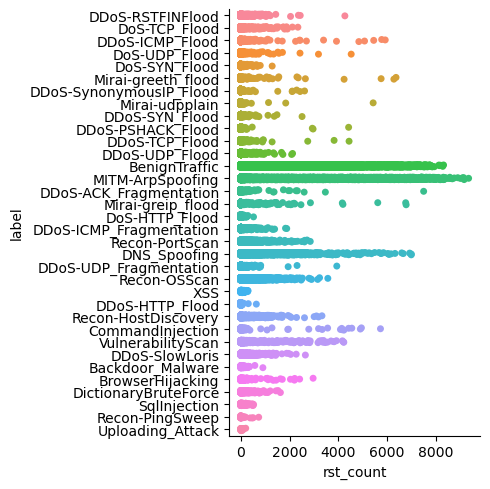

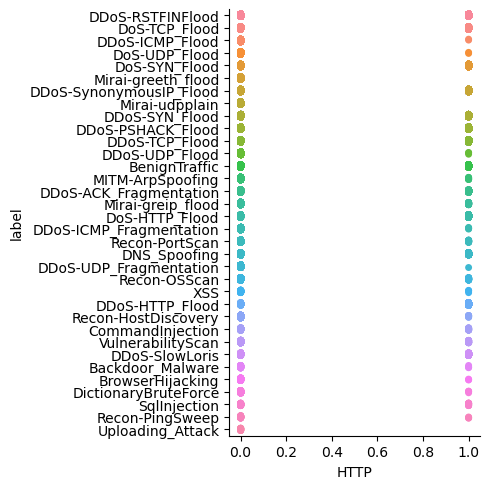

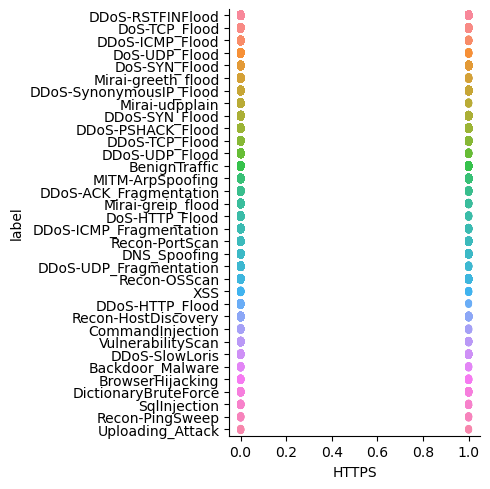

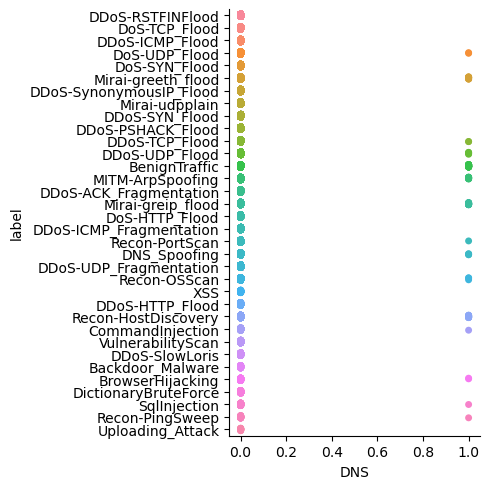

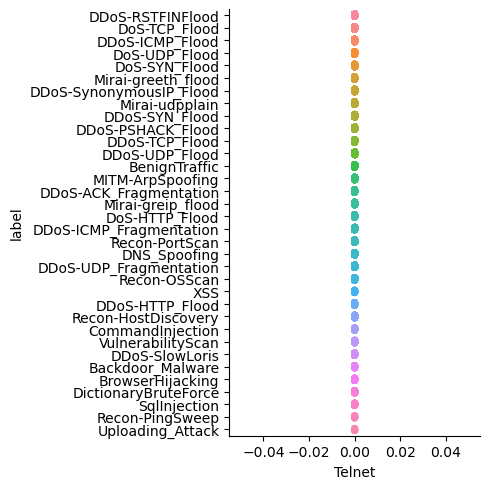

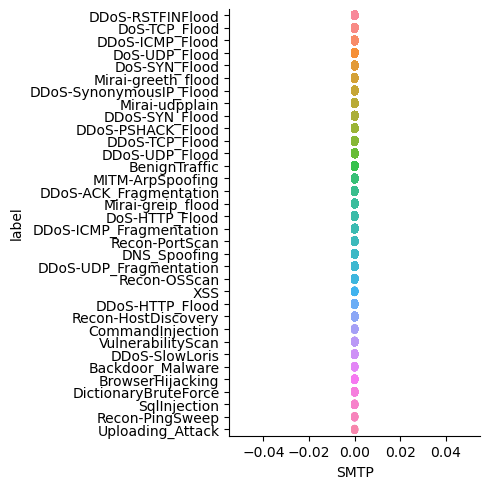

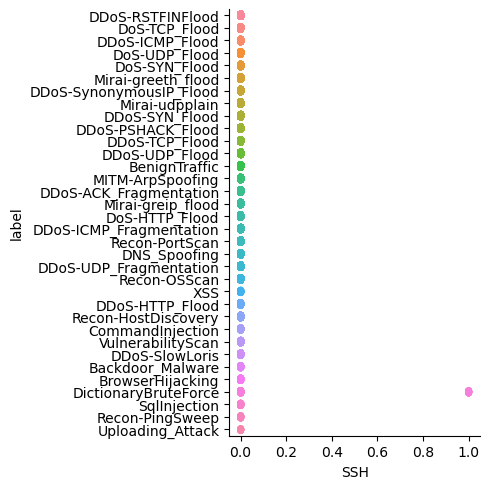

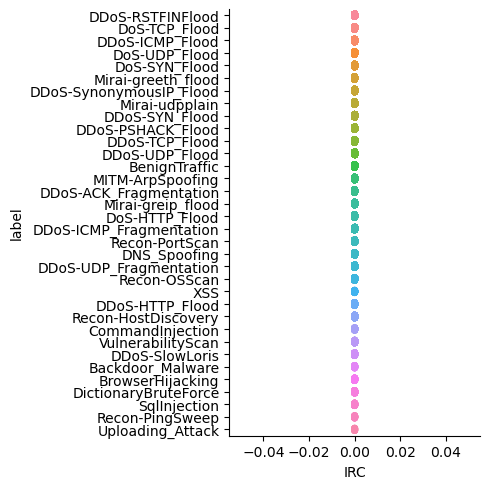

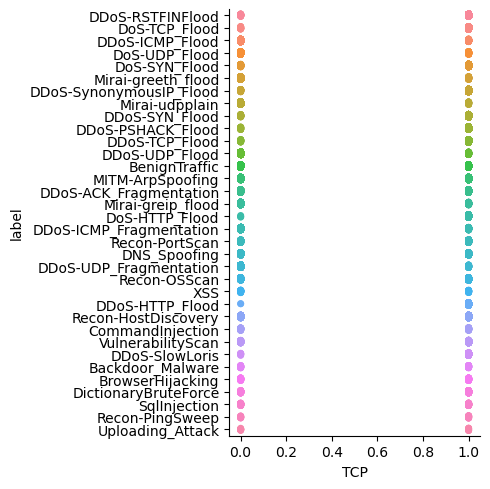

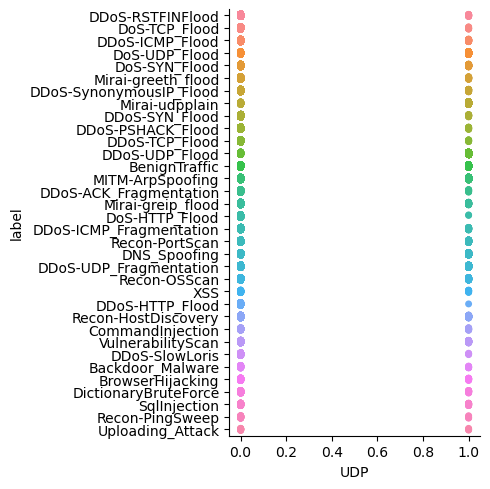

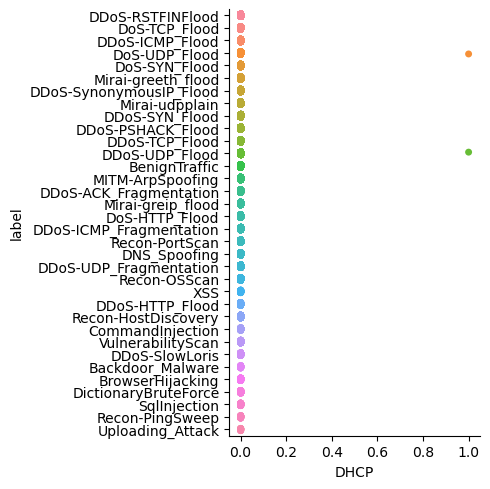

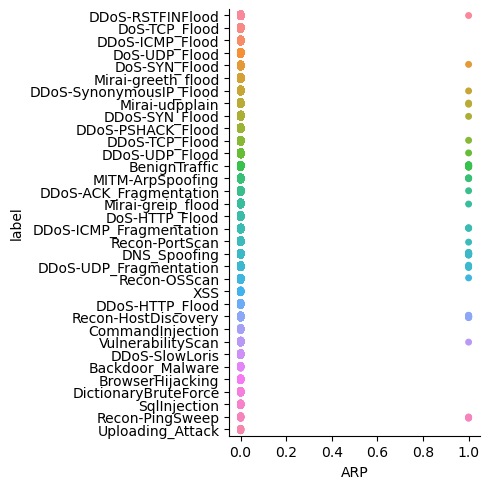

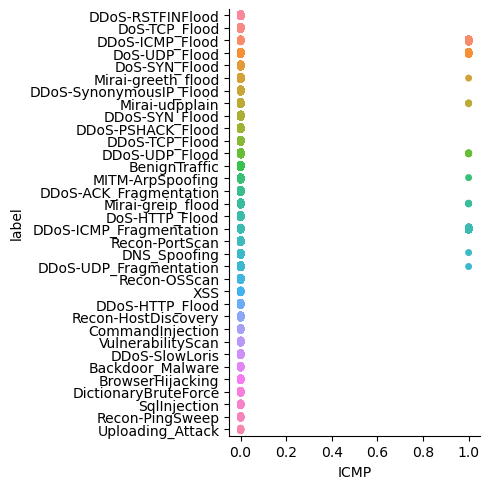

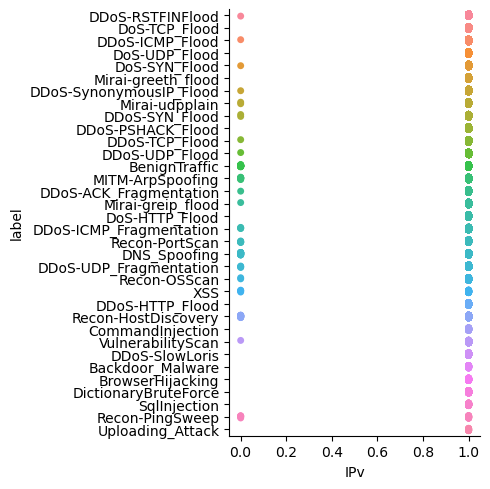

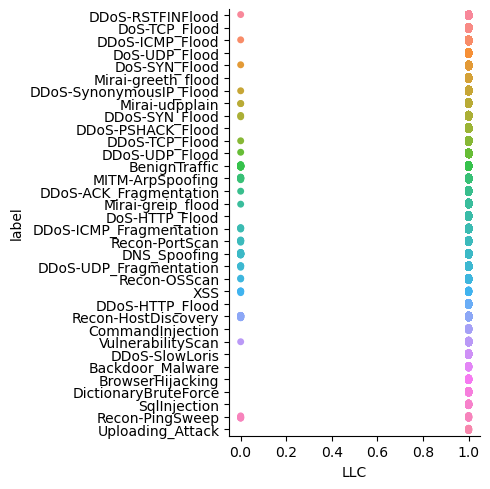

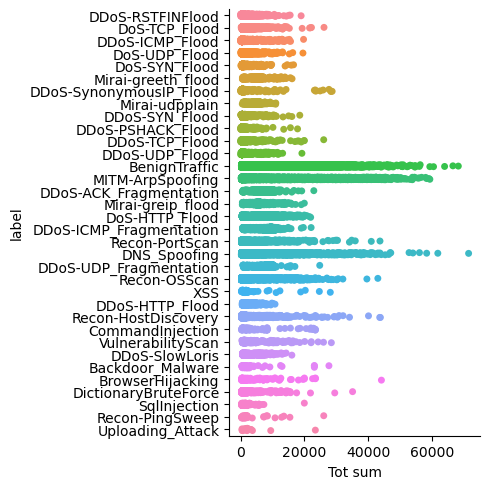

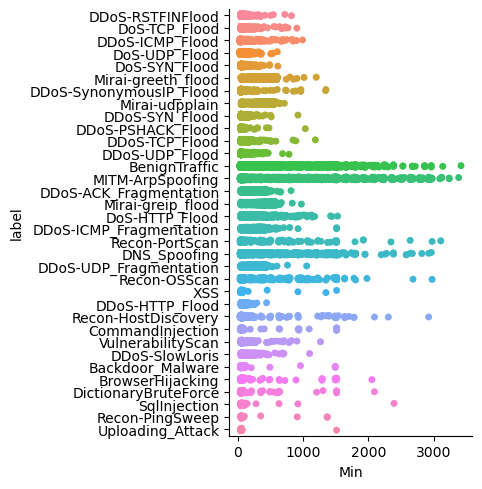

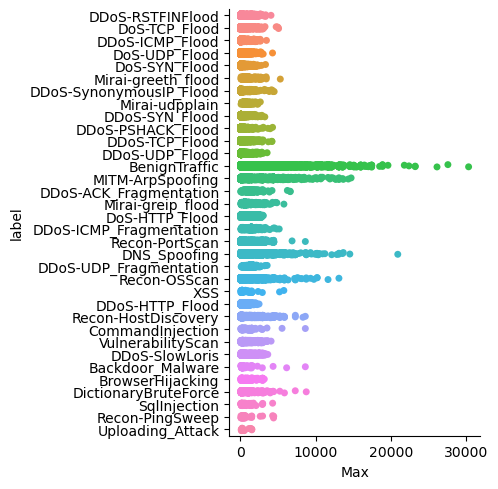

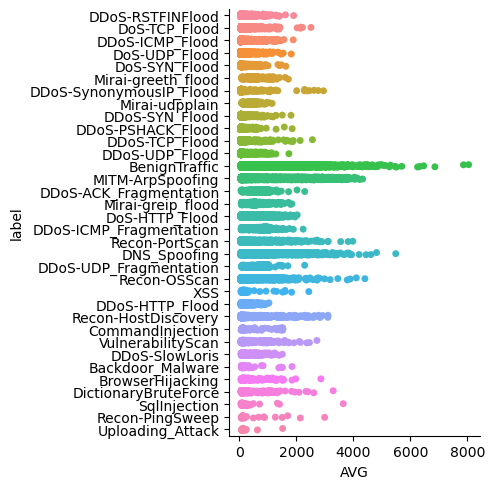

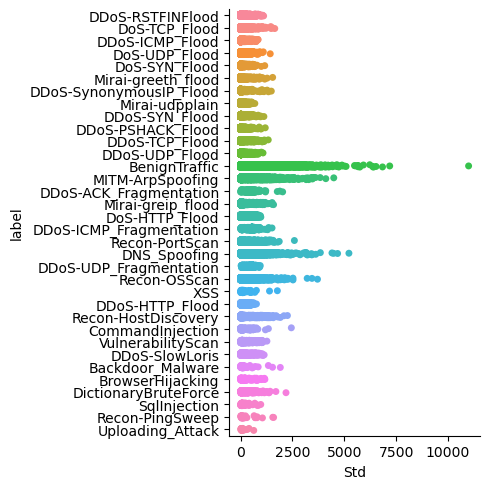

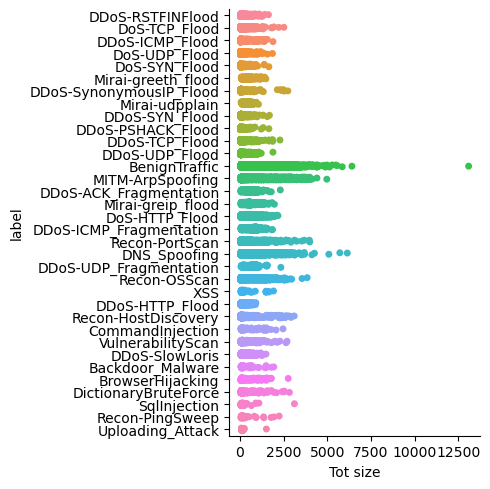

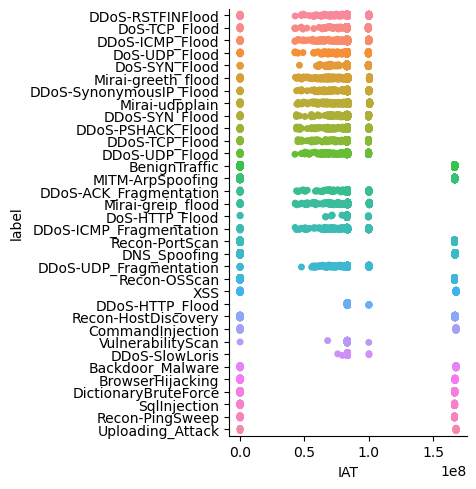

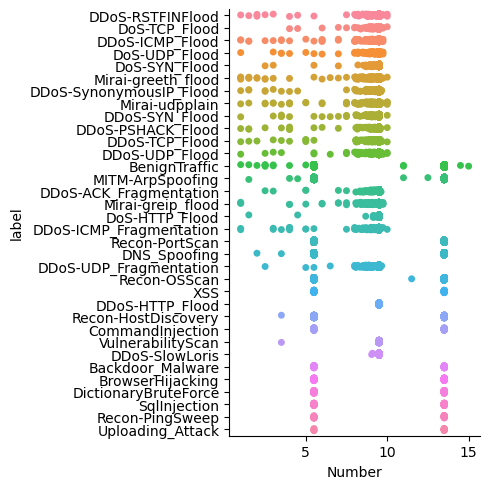

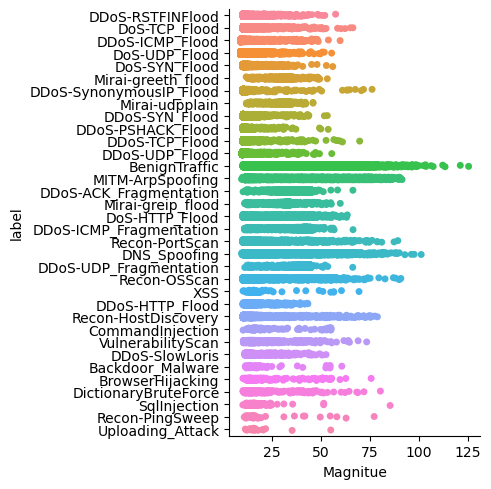

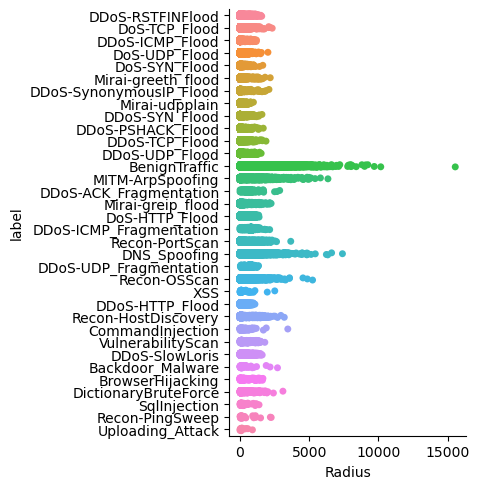

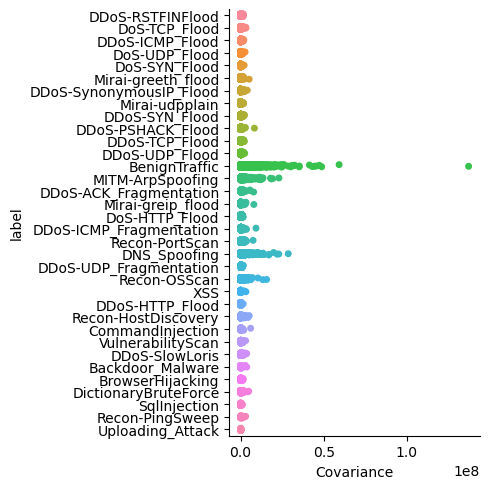

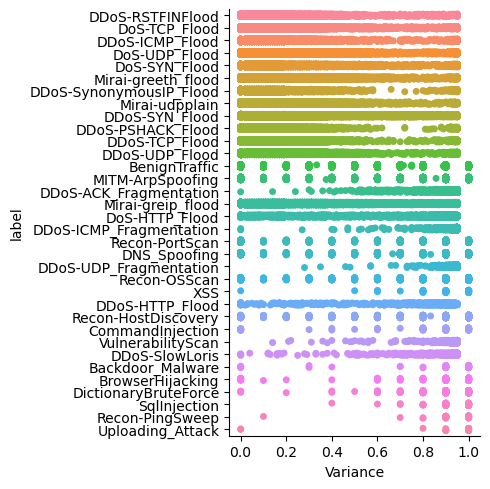

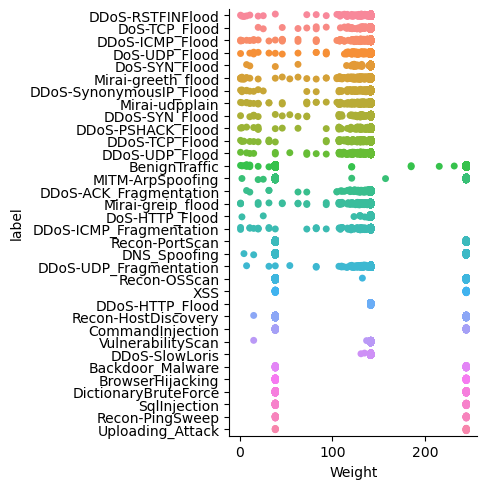

In [ ]:
# create catplots showing distributions of outputs against all inputs
for name in intru_table.columns:
    if name not in ['label']:
        sns.catplot(data=intru_table, x=name, y='label')

## Fitting the Initial Model and Measuring Its Performance

In [9]:
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 36, activation = 'relu', input_dim = 35))
classifier.add(Dense(units = 35, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.7330
Epoch 2/50
29492/29492 [==============================] - 33s 1ms/step - loss: 0.5364
Epoch 3/50
29492/29492 [==============================] - 35s 1ms/step - loss: 0.5062
Epoch 4/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.4885
Epoch 5/50
29492/29492 [==============================] - 28s 960us/step - loss: 0.4794
Epoch 6/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4736
Epoch 7/50
29492/29492 [==============================] - 35s 1ms/step - loss: 0.4690
Epoch 8/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4650
Epoch 9/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4615
Epoch 10/50
29492/29492 [==============================] - 33s 1ms/step - loss: 0.4585
Epoch 11/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4561
Epoch 12/50
29492/29492 [=========================

In [10]:
# INITIAL STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
initial_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", initial_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
initial_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", initial_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 23s 788us/step
Model Training Accuracy (avg.): 0.7900885540898384
Model Training Precision (avg.): 0.6046030488353284
Model Training Recall (avg.): 0.4598748252039447
Model Training MSE: 0.011849981945609444
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.83      0.76      0.79     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.99      0.98      0.99      5796
        DDoS-HTTP_Flood       0.62      0.55      0.58       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood      

## Identifying the Initial Model's Fitting Characteristics

In [11]:
# LOW1 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 16, activation = 'relu', input_dim = 35))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.8425
Epoch 2/50
29492/29492 [==============================] - 29s 990us/step - loss: 0.5609
Epoch 3/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.5304
Epoch 4/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.5150
Epoch 5/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.5041
Epoch 6/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4959
Epoch 7/50
29492/29492 [==============================] - 29s 1000us/step - loss: 0.4899
Epoch 8/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4856
Epoch 9/50
29492/29492 [==============================] - 29s 995us/step - loss: 0.4828
Epoch 10/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4804
Epoch 11/50
29492/29492 [==============================] - 29s 994us/step - loss: 0.4786
Epoch 12/50
29492/29492 [==================

In [12]:
# LOW1 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
low1_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", low1_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
low1_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", low1_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 23s 775us/step
Model Training Accuracy (avg.): 0.7763333711271494
Model Training Precision (avg.): 0.5330412755881193
Model Training Recall (avg.): 0.433353845574752
Model Training MSE: 0.012340782122556807
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.76      0.86      0.81     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.98      0.96      0.97      5796
        DDoS-HTTP_Flood       0.68      0.03      0.06       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.98      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood       

In [13]:
# LOW2 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 26, activation = 'relu', input_dim = 35))
classifier.add(Dense(units = 25, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.7591
Epoch 2/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.5438
Epoch 3/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.5142
Epoch 4/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4967
Epoch 5/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4868
Epoch 6/50
29492/29492 [==============================] - 29s 991us/step - loss: 0.4806
Epoch 7/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4764
Epoch 8/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4730
Epoch 9/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4700
Epoch 10/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4674
Epoch 11/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4647
Epoch 12/50
29492/29492 [=========================

In [14]:
# LOW2 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
low2_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", low2_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
low2_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", low2_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 24s 815us/step
Model Training Accuracy (avg.): 0.7549350069989202
Model Training Precision (avg.): 0.6005142001380789
Model Training Recall (avg.): 0.4719180867818049
Model Training MSE: 0.013887731422973323
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.73      0.93      0.82     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.98      0.98      0.98      5796
        DDoS-HTTP_Flood       0.62      0.51      0.56       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood      

In [15]:
# HIGH1 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 46, activation = 'relu', input_dim = 35))
classifier.add(Dense(units = 45, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 35s 1ms/step - loss: 0.7358
Epoch 2/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.5341
Epoch 3/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.5001
Epoch 4/50
29492/29492 [==============================] - 29s 975us/step - loss: 0.4840
Epoch 5/50
29492/29492 [==============================] - 29s 990us/step - loss: 0.4767
Epoch 6/50
29492/29492 [==============================] - 28s 945us/step - loss: 0.4722
Epoch 7/50
29492/29492 [==============================] - 28s 933us/step - loss: 0.4683
Epoch 8/50
29492/29492 [==============================] - 28s 964us/step - loss: 0.4648
Epoch 9/50
29492/29492 [==============================] - 29s 971us/step - loss: 0.4618
Epoch 10/50
29492/29492 [==============================] - 28s 960us/step - loss: 0.4590
Epoch 11/50
29492/29492 [==============================] - 28s 962us/step - loss: 0.4566
Epoch 12/50
29492/29492 [===========

In [16]:
# HIGH1 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
high1_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", high1_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
high1_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", high1_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 22s 754us/step
Model Training Accuracy (avg.): 0.7852788494855979
Model Training Precision (avg.): 0.6127326442341196
Model Training Recall (avg.): 0.46653659393040675
Model Training MSE: 0.012108191208119533
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.78      0.85      0.81     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.98      0.98      0.98      5796
        DDoS-HTTP_Flood       0.65      0.47      0.54       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood     

In [17]:
# HIGH2 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 56, activation = 'relu', input_dim = 35))
classifier.add(Dense(units = 55, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 30s 996us/step - loss: 0.7142
Epoch 2/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.5263
Epoch 3/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4942
Epoch 4/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4832
Epoch 5/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4775
Epoch 6/50
29492/29492 [==============================] - 33s 1ms/step - loss: 0.4734
Epoch 7/50
29492/29492 [==============================] - 29s 996us/step - loss: 0.4702
Epoch 8/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4676
Epoch 9/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4654
Epoch 10/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4630
Epoch 11/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.4608
Epoch 12/50
29492/29492 [=======================

In [18]:
# HIGH2 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
high2_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", high2_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
high2_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", high2_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 24s 817us/step
Model Training Accuracy (avg.): 0.7990181378527673
Model Training Precision (avg.): 0.6380845247800311
Model Training Recall (avg.): 0.4760772627054606
Model Training MSE: 0.011265871143199772
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.76      0.92      0.83     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.99      0.98      0.98      5796
        DDoS-HTTP_Flood       0.68      0.51      0.58       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood      

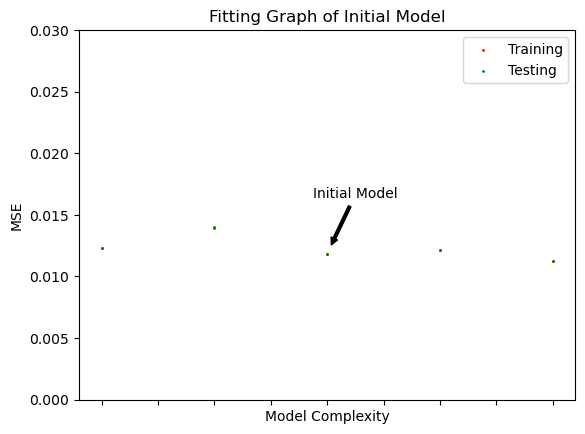

In [19]:
complexities = [1, 2, 3, 4, 5]
train_mse = [low1_MSE_train, low2_MSE_train, initial_MSE_train, high1_MSE_train, high2_MSE_train]
test_mse = [low1_MSE_test, low2_MSE_test, initial_MSE_train, high1_MSE_test, high2_MSE_test]
plt.scatter(complexities, train_mse, s = 1, c='r', label='Training')
plt.scatter(complexities, test_mse, s = 1, c='g', label='Testing')
plt.xlabel('Model Complexity')
plt.xticks(visible=False)
plt.ylim(0, 0.03)
plt.ylabel('MSE')
plt.title('Fitting Graph of Initial Model')
plt.annotate('Initial Model', (complexities[2], test_mse[2]), textcoords='offset points', xytext=(-10, 40), 
             arrowprops=dict(arrowstyle='simple', facecolor='black', shrinkB=7))
plt.legend()
plt.show()

## Improving the Initial Model